# Модель

In [14]:
import math
import pandas as pd
import scipy.stats as stats
import numpy as np

In [15]:
def get_poisson_params(data):
    total_count = sum(data['m'])
    weighted_mean = sum(data['k'] * data['m']) / total_count
    return weighted_mean

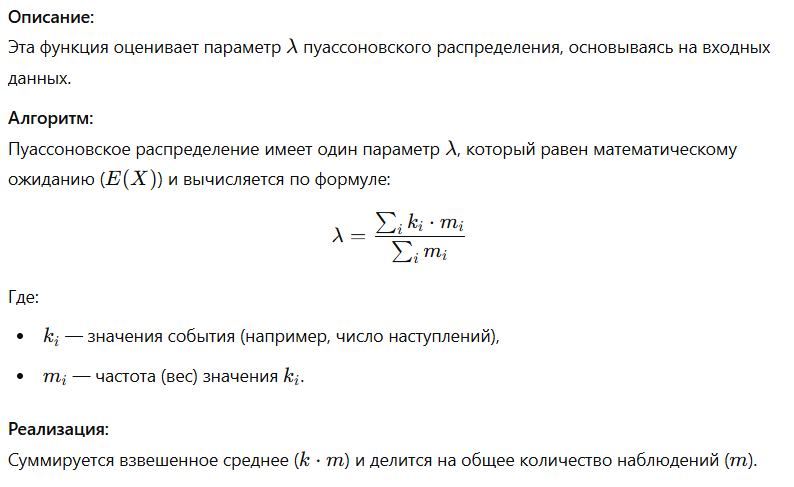

In [16]:
def get_poisson_gamma_params(data):
    total_count = sum(data['m'])
    mean_value = sum(data['k'] * data['m']) / total_count
    second_moment = sum((data['k'] ** 2) * data['m']) / total_count
    variance = second_moment - mean_value**2
    alpha = mean_value**2 / (variance - mean_value)
    beta = mean_value / (variance - mean_value)
    return alpha, beta

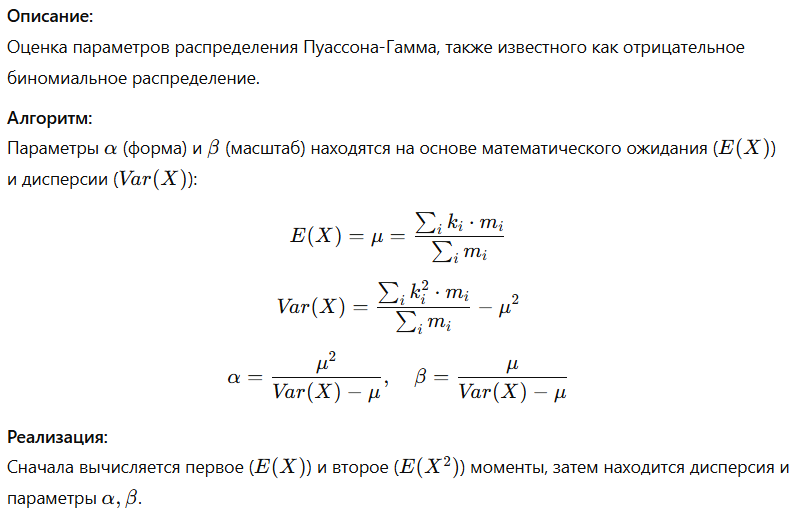

In [17]:
def get_poisson_gaussian_params(data):
    total_count = sum(data['m'])
    mean_value = sum(data['k'] * data['m']) / total_count
    second_moment = sum((data['k'] ** 2) * data['m']) / total_count
    variance = second_moment - mean_value**2
    gamma_param = mean_value
    eta_param = (variance / mean_value) - 1
    return gamma_param, eta_param

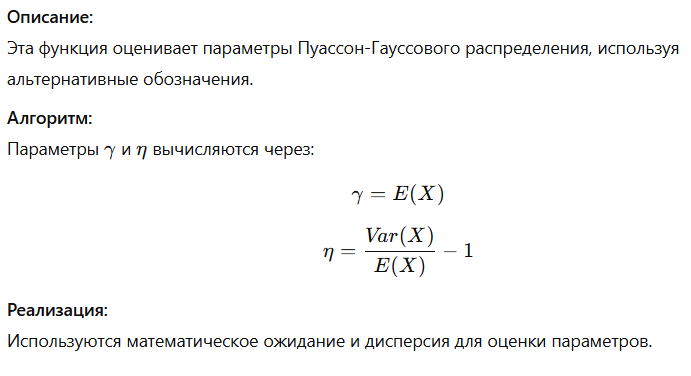

In [18]:
def get_lemaire_params(data):
    total_count = sum(data['m'])
    mean_value = sum(data['k'] * data['m']) / total_count
    second_moment = sum((data['k'] ** 2) * data['m']) / total_count
    third_moment = sum((data['k'] ** 3) * data['m']) / total_count

    a = mean_value
    b = second_moment - mean_value
    c = third_moment - 3 * second_moment + 2 * mean_value
    discriminant = (c - a * b) / (b - a ** 2)
    additional_term = (a * c - b ** 2) / (b - a ** 2)

    λ1 = (discriminant - math.sqrt(discriminant**2 - 4 * additional_term)) / 2
    λ2 = (discriminant + math.sqrt(discriminant**2 - 4 * additional_term)) / 2
    weight = (a - λ2) / (λ1 - λ2)
    return weight, λ1, λ2

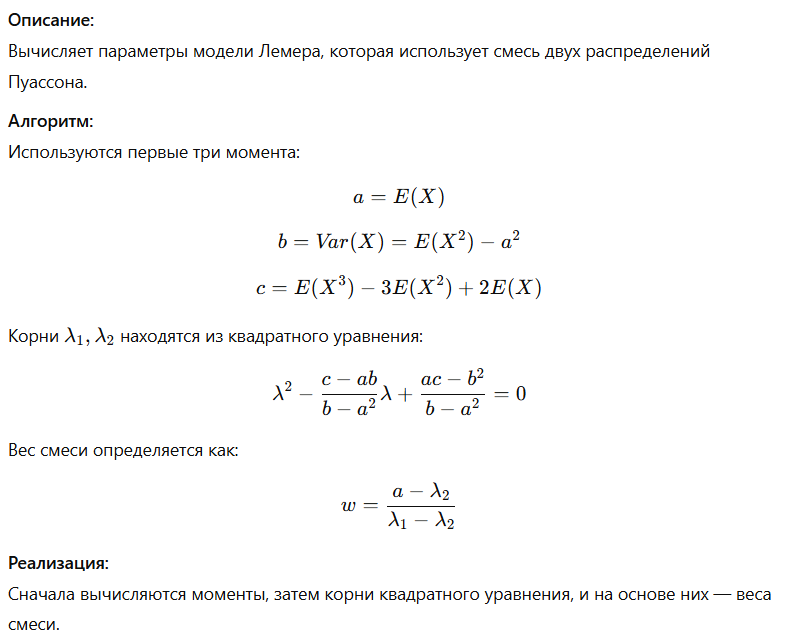

In [19]:
def xlop(data):
    if len(data) < 4:
        return data
    reduced_data = data.copy()
    while len(reduced_data) > 1 and reduced_data.iloc[-1]['m'] < 5:
        prev_idx = reduced_data.index[-2]
        for col in reduced_data.columns:
            reduced_data.loc[prev_idx, col] += reduced_data.iloc[-1][col]
        reduced_data = reduced_data.drop(reduced_data.index[-1])
    return reduced_data

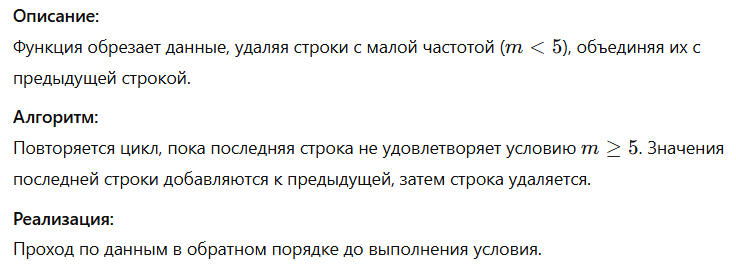

In [20]:
def get_poisson_data(data, λ):
    poisson_dist = data.copy()
    total_count = sum(data['m'])
    poisson_dist['p'] = stats.poisson.pmf(data['k'], λ)
    poisson_dist['m_estimand'] = round(poisson_dist['p'] * total_count)
    return xlop(poisson_dist)

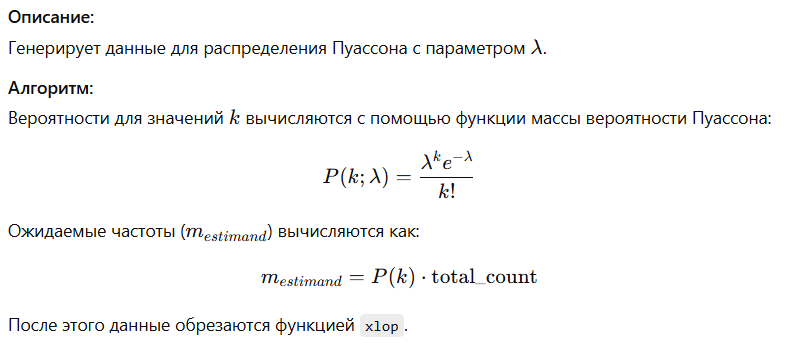

In [21]:
def get_poisson_gamma_data(data, alpha, beta):
    pg_dist = data.copy()
    total_count = sum(data['m'])
    pg_dist['p'] = stats.nbinom.pmf(data['k'], alpha, beta / (1 + beta))
    pg_dist['m_estimand'] = round(pg_dist['p'] * total_count)
    return pg_dist

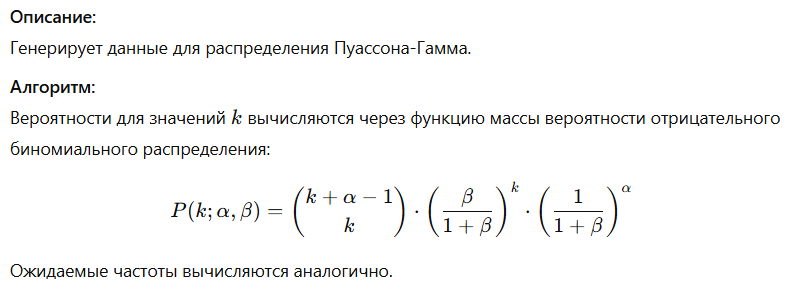

In [22]:
def get_poisson_gaussian_data(data, gamma_param, eta_param):
    pg_dist = data.copy()
    total_count = sum(data['m'])
    probabilities = np.zeros(data['k'].max() + 1)
    for idx in range(probabilities.size):
        if idx == 0:
            probabilities[0] = math.exp(gamma_param * (1 - math.sqrt(1 + 2 * eta_param)) / eta_param)
        elif idx == 1:
            probabilities[1] = probabilities[0] * gamma_param / math.sqrt(1 + 2 * eta_param)
        else:
            probabilities[idx] = ((probabilities[idx - 1] * eta_param * (idx - 1) * (2 * idx - 3) +
                                    probabilities[idx - 2] * gamma_param**2) /
                                   ((1 + 2 * eta_param) * idx * (idx - 1)))
    pg_dist['p'] = probabilities[data['k']]
    pg_dist['m_estimand'] = round(pg_dist['p'] * total_count)
    return xlop(pg_dist)

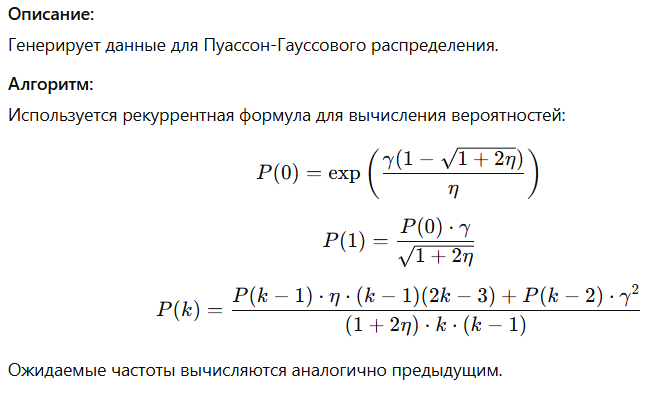

In [23]:
def get_lemaire_data(data, weight1, λ1, λ2):
    lemaire_dist = data.copy()
    total_count = sum(data['m'])
    weight2 = 1 - weight1
    lemaire_dist['p'] = (weight1 * stats.poisson.pmf(data['k'], λ1) +
                         weight2 * stats.poisson.pmf(data['k'], λ2))
    lemaire_dist['m_estimand'] = round(lemaire_dist['p'] * total_count)
    return xlop(lemaire_dist)

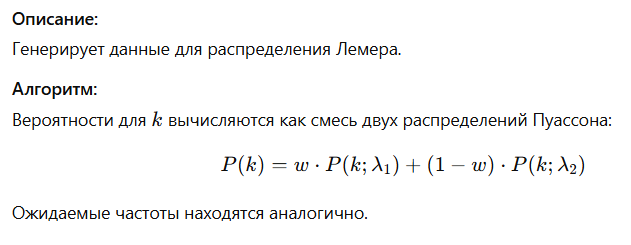

In [24]:
def get_pvalue(new_data, num_params):
    filtered_data = new_data[new_data['m_estimand'] > 0]
    chi_squared_stat = sum((filtered_data['m'] - filtered_data['m_estimand'])**2 / filtered_data['m_estimand'])
    dof = len(filtered_data) - num_params - 1
    p_val = 1 - stats.chi2.cdf(chi_squared_stat, dof)
    return p_val

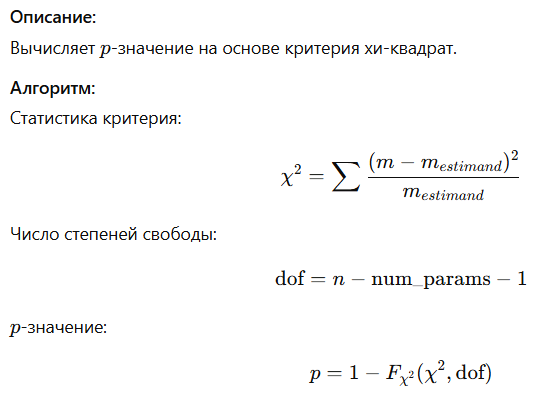

In [25]:
def get_result(threshold, p_poisson, p_pg, p_pg_dist, p_lemaire):
    methods = ['Poisson', 'Poisson-Gamma', 'Inverse Gaussian', 'Lemaire']
    results = pd.DataFrame({'Method': methods, 'p-value': [p_poisson, p_pg, p_pg_dist, p_lemaire]})
    results['Rank'] = 'Not Suitable'
    passing_models = results[results['p-value'] > threshold].sort_values('p-value', ascending=False)
    if len(passing_models) > 0:
        for rank, idx in enumerate(passing_models.index, start=1):
            results.loc[idx, 'Rank'] = rank
    results['p-value'] = results['p-value'].map('{:.14f}'.format)
    return results

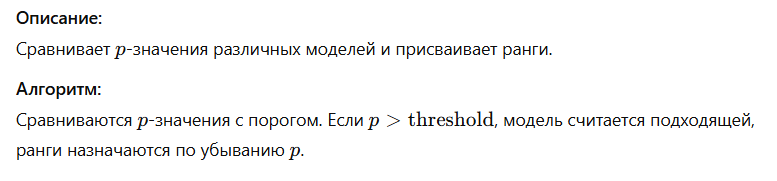

# Тестирование

In [26]:
df = pd.DataFrame({
    'k': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'm': [1624, 490, 208, 98, 48, 23, 10, 5, 3, 2, 1]
})

α = 0.05

λ = get_poisson_params(df)
a, b = get_poisson_gamma_params(df)
g, h = get_poisson_gaussian_params(df)
a1, λ1, λ2 = get_lemaire_params(df)

result = get_result(
    α,
    get_pvalue(
        get_poisson_data(df, λ), 1),
    get_pvalue(
        get_poisson_gamma_data(df, a, b), 2),
    get_pvalue(
        get_poisson_gaussian_data(df, g, h), 2),
    get_pvalue(
        get_lemaire_data(df, a1, λ1, λ2), 3)
)

print(result)


             Method           p-value          Rank
0           Poisson  0.00000000000000  Not Suitable
1     Poisson-Gamma  0.99230828625810             1
2  Inverse Gaussian  0.00243887483111  Not Suitable
3           Lemaire  0.00000011461736  Not Suitable


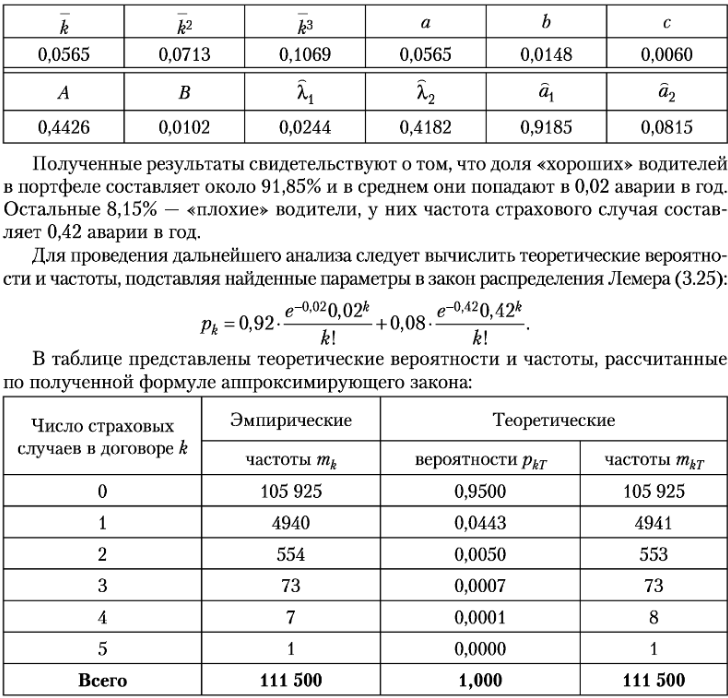


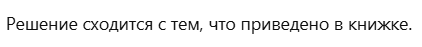